# Topic modelling
## r/conspiracy comments containing "vaccine"
**Group members**
* Maheep T
* Sanchi S
***

## Import modules

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
import nltk
import re
import string
import textwrap
from dfply import *
import preprocessor as p
import unicodedata
import pickle
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from kwic import keywords_in_context
from operator import itemgetter
from datetime import datetime as dt
from keyness import log_likelihood
from scipy.spatial.distance import cdist, pdist
from IPython.display import Image
# sklearn
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

# download
# nltk.download
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

## Read files

In [4]:
base_dir = 'C:\\Users\\Maheep\\Documents\\TUM\\WiSe2020\\CSS\\code\\reddit-anti-vax' #import os; os.getcwd()
data_dir = base_dir + '\\data'

filename = data_dir + "\\" + "comments_vaccine_praw.csv" # comments_vaccine/_praw.csv
df_com = pd.read_csv(filename)
df_com = df_com.rename({'Submission ID': 's_id', 'Comment ID': 'c_id', 'Body': 'text', 'Publish Date': 'date', 'Author': 'user', 'Score': 'score', 'Permalink': 'link'}, axis=1)

filename = data_dir + "\\" + "submissions_vaccine.csv"
df_sub = pd.read_csv(filename)
df_sub = df_sub.rename({'Post ID': 's_id', 'Title': 'text', 'Publish Date': 'date', 'Score': 'score', 'Permalink': 'link'}, axis=1)

filename = data_dir + "\\" + "reddit_bots.csv"
df_bots = pd.read_csv(filename)
list_bots = df_bots['Name'].tolist() ;

In [5]:
df_com['date'] =  df_com['date'].apply(lambda x: dt.strptime(x,'%Y-%m-%d %H:%M:%S')) # convert str to datetime

In [6]:
# out_file for temp output
out_dir = base_dir + '\\output'
out_file = out_dir + "\\" + "out_file.csv"

## Collect Data

* Use pushshift to query "vaccine" submissions (reddit posts)

In [7]:
print(df_sub.shape[0], " rows in submission data")

2905  rows in submission data


* Use PRAW to collect comments by iterating over all "vaccine" submissions
([praw docs](https://praw.readthedocs.io/en/latest/tutorials/comments.html))
    * pushshift comment data has a lot of missing values ([Gaffney, Matias 2018](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0200162) )

In [8]:
print(df_com.shape[0], "rows in comment data")

77366 rows in comment data


## Clean-up and pre-processing

* Remove comments -
  * where user and text were [deleted]
  * where user is a  bot (list of bots from [Klein et. al. 2019](https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0225098) )

In [9]:
df_com_pp = df_com.copy() # copy to pre-process dataframe
df_com_pp = df_com_pp >> mask(~((X.user == '[deleted]') & (X.text == '[deleted]'))) # >> summarize(count=n(X.c_id))
df_com_pp = df_com_pp[~df_com_pp['user'].isin(list_bots)]

In [10]:
# test, remove later
df_com_pp['text_og'] = df_com_pp['text']

* Clean - removes URLs, Hashtags, Mentions, Reserved words (RT, FAV), Emojis, Smileys ([Source](https://pypi.org/project/tweet-preprocessor/))

In [11]:
def func_clean(text):
    text = unicodedata.normalize("NFKC", text)  # remove unicode chars like emojis and breaks
    #text = re.sub(r'[^\x00-\x7F]+', " ", text)
    text = re.sub(r'[\r|\n|\r\n]+', " ", text) # remove extra newlines
    text = re.sub(r'[(){}[\]><]+', "", text) # remove brackets 
    text = re.sub(r'\/?u\/[-A-Za-z0-9+&@#/%?=~_|!:,.;]+[-A-Za-z0-9+&@#/%=~_|]', "", text) # remove user names
    text = p.clean(text) # from preprocessor lib
    return text
    
df_com_pp['text'] = df_com_pp['text'].apply(func_clean)

* Expanding contractions ([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch03%20-%20Processing%20and%20Understanding%20Text/Ch03a%20-%20Text%20Wrangling.ipynb))

In [12]:
from contractions import CONTRACTION_MAP
import re

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

df_com_pp['text'] = df_com_pp['text'].apply(expand_contractions)

* Tokenise <= lowercase + remove punctuation ([Source](https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e))

In [13]:
df_com_pp['text'] = df_com_pp['text'].apply(lambda x: x.lower()) # lowercase
df_com_pp['text'] = df_com_pp['text'].apply(lambda x: x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))) # remove punctuation

tt = TweetTokenizer() # does better than default word_tokenizer
df_com_pp['text'] = df_com_pp['text'].apply(tt.tokenize) 

* Fix repetition in words e.g. "Coooolll!" => "Cool!" ([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch03%20-%20Processing%20and%20Understanding%20Text/Ch03a%20-%20Text%20Wrangling.ipynb))

In [14]:
def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
            
    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

df_com_pp['text'] = df_com_pp['text'].apply(remove_repeated_characters)

* Remove tokens that are integers

In [15]:
def func_filter_int(l):
    new_l = list()
    for tkn in l:
        tkn = re.sub(r'[-+*/$%.,]+', '', tkn)
        if not tkn.isnumeric() : new_l.append(tkn)
    return new_l

df_com_pp['text'] = df_com_pp['text'].apply(func_filter_int)

* Remove stopwords

In [16]:
stop_words = stopwords.words('english')
def func_filter_stopwords(l):
    return list([w for w in l if not w in stop_words])
df_com_pp['text'] = df_com_pp['text'].apply(func_filter_stopwords)

* Stemming (not lemmatising as it needs the whole sentence context to be effective)

In [17]:
ps = PorterStemmer()
df_com_pp['text'] = df_com_pp['text'].apply(lambda x: [ps.stem(word) for word in x])


* ~~Lemmatizing (preferred over a stemmer because it produces more readable words. Output that is easy to read is very desirable in topic modelling.) ([Source](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py))~~

In [18]:
# lemmatizer = WordNetLemmatizer()
# df_com_pp['text'] = df_com_pp['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

* save/load data because it takes long to do preprocessing

In [19]:
filename = data_dir + "\\" + "df_com_pp.dat"
# pickle.dump(df_com_pp, open(filename, 'wb')) # SAVE
# df_com_pp = pickle.load(open(filename, 'rb')) # LOAD

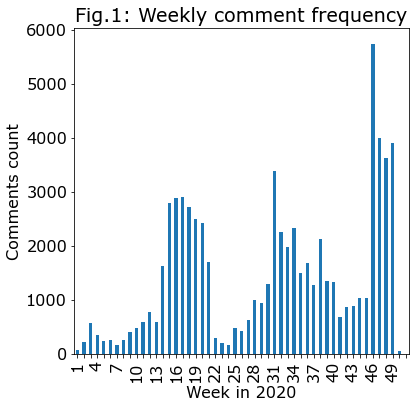

In [393]:
df_com_pp['week'] = pd.to_datetime(df_com_pp['date']).dt.isocalendar().week
rcParams['xtick.labelsize'] = 16

df_new = df_com_pp.groupby('week').size()

fig = plt.figure(figsize=[6,6])
ax = plt.subplot()
ax = df_new.plot.bar()
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Comments count')
ax.set_title('Fig.1: Weekly comment frequency')
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 3 != 0:
        label.set_visible(False)
# #plt.grid()
plt.savefig(out_dir+'\\overall_com_freq.pdf', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

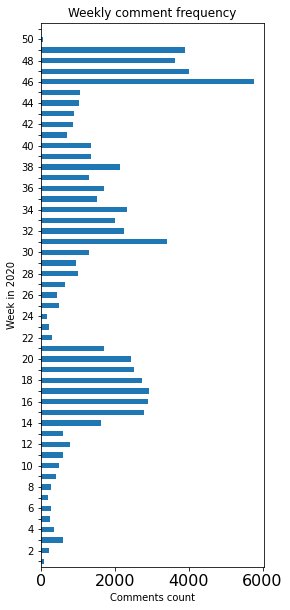

In [25]:
#df_com_pp['week'] = pd.to_datetime(df_com_pp['date']).dt.isocalendar().week
df_new = df_com_pp.groupby('week').size()

fig = plt.figure(figsize=[4,10])
ax = plt.subplot()
ax = df_new.plot.barh()
ax.set_ylabel('Week in 2020')
ax.set_xlabel('Comments count')
ax.set_title('Weekly comment frequency')
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)
# #plt.grid()
plt.show()

---
## Non-negative Matrix Factorisation

Topic Models with Non-Negative Matrix Factorization (NMF)

([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch06%20-%20Text%20Summarization%20and%20Topic%20Models/Ch06c%20-%20Topic%20Modeling%20with%20scikit-learn.ipynb)) - Sarkar, Text Analytics in Python

Alternate - NMF using sklearn ([Source](https://gist.github.com/ravishchawla/3f346318b85fa07196b761443b123bba))

We find bigrams in the documents. Bigrams are sets of two adjacent words. Using bigrams we can get phrases like “machine_learning” in our output (spaces are replaced with underscores); without bigrams we would only get “machine” and “learning”.

Note that in the code below, we find bigrams and then add them to the original data, because we would like to keep the words “machine” and “learning” as well as the bigram “machine_learning”.

In [26]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(df_com_pp['text'].tolist(), min_count=20)
for idx in range(len(df_com_pp['text'].tolist())):
    for token in bigram[df_com_pp['text'].tolist()[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            #docs[idx].append(token)
            df_com_pp.iloc[idx, df_com_pp.columns.get_loc('text')].append(token)

* ~~Remove rare words and common words based on their document frequency ~~

~~Remove words that appear in less than 20 documents or in more than 50% of the documents.~~

In [27]:
# # Remove rare and common tokens.
# from gensim.corpora import Dictionary

# # Create a dictionary representation of the documents.
# dictionary = Dictionary(df_com_pp['text'].tolist())

# # Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)

---

In [322]:
cv = CountVectorizer(min_df=20, max_df=1.0, ngram_range=(1,1),
                     token_pattern=None, tokenizer=lambda doc: doc,
                     preprocessor=lambda doc: doc)
cv_features = cv.fit_transform(df_com_pp['text']) #Learn the vocabulary dictionary (fit) and return document-term matrix (transform)
cv_features.shape
vocabulary = np.array(cv.get_feature_names())
print('Total Vocabulary Size:', len(vocabulary))

Total Vocabulary Size: 5548


* tf-Idf transformation

In [323]:
transformer = TfidfTransformer(smooth_idf=False);
cv_features = transformer.fit_transform(cv_features);

# from sklearn.preprocessing import normalize;
# cv_features = normalize(cv_features, norm='l1', axis=1)

In [33]:
%%time
num_topics=10
nmf_model = NMF(n_components=num_topics, solver='cd', max_iter=2000,
                random_state=42, alpha=.1, l1_ratio=.85)
document_topics = nmf_model.fit_transform(cv_features)

C:\Users\Maheep\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


Wall time: 23.1 s


In [34]:
top_terms=20
topic_terms = nmf_model.components_
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
#pd.set_option('display.max_colwidth', None)
topics_df = pd.DataFrame(topics,
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, num_topics+1)])
topics_df

,Terms per Topic
Topic1,"remov, remov_rule, rule, r, comment, user, you..."
Topic2,"vaccin, peopl, get, would, know, take, like, t..."
Topic3,"thank, post, thank_share, thank_god, interest,..."
Topic4,"lol, ok, dude, exactli, that, love, sub, post,..."
Topic5,"bill, gate, bill_gate, fund, trust, evil, foun..."
Topic6,"fuck, shit, guy, yeah, idiot, dumb, stupid, gi..."
Topic7,"flu, shot, flu_shot, get, got, year, everi_yea..."
Topic8,"ye, ah_ye, ah, pleas, exactli, agre, cours, tr..."
Topic9,"sourc, link, claim, pleas, read, articl, inter..."
Topic10,"good, good_luck, luck, point, bot, question, g..."


* Viewing topic dominance per document using the document-topic matrix

In [35]:
pd.options.display.float_format = '{:,.3f}'.format
dt_df = pd.DataFrame(document_topics, 
                     columns=['T'+str(i) for i in range(1, num_topics+1)])
dt_df.head(5)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.000,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.006,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000
2,0.000,0.007,0.033,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.019
4,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


* determine the most relevant comment for each topic based on the topic dominance scores 

In [36]:
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 200)

max_score_topics = dt_df.max(axis=0)
dominant_topics = max_score_topics.index
term_score = max_score_topics.values
document_numbers = [dt_df[dt_df[t] == max_score_topics.loc[t]].index[0]
                       for t in dominant_topics]
documents = [df_com.iloc[i, df_com.columns.get_loc('text')] for i in document_numbers]

results_df = pd.DataFrame({'Dominant Topic': dominant_topics, 'Max Score': term_score,
                          'Paper Num': document_numbers, 'Topic': topics_df['Terms per Topic'], 
                          'Paper Name': documents})
results_df

,Dominant Topic,Max Score,Paper Num,Topic,Paper Name
Topic1,T1,0.06954,95,"remov, remov_rule, rule, r, comment, user, youtub, video, address_argument, meta_sticki, remov_section, rather_user, user_rather, argument_happi, comment_outsid, comment_per, reaprov, rule_ask, co...","Again, if there is already a treatment, placebos are not used. The existing treatment is.\n\nPlacebos are used to see if the result is better than placebo... however if there is a treatment alrea..."
Topic2,T2,0.03069,64479,"vaccin, peopl, get, would, know, take, like, think, say, go, one, make, want, dont, work, covid, viru, even, right, test",I’m not an extremist. I’m just looking at things logically.\n\nNot everything is true and not everything is a lie.\n\nThe people who control the narratives will hide a lie between two truths. \n\n...
Topic3,T3,0.08437,793,"thank, post, thank_share, thank_god, interest, info, great, share, look, link, much, check, appreci, laugh, friend, god, wow, cool, inform, man",Herd immunity.
Topic4,T4,0.07991,384,"lol, ok, dude, exactli, that, love, sub, post, im, k, right, nice, yeah, yea, thought, funni, dont, vote, bro, realli",source?...again
Topic5,T5,0.08285,1959,"bill, gate, bill_gate, fund, trust, evil, foundat, vaccin, melinda, gate_foundat, bill_melinda, ss, africa, epstein, microchip, microsoft, patent, involv, depopul, tri",[deleted]
Topic6,T6,0.08010,2434,"fuck, shit, guy, yeah, idiot, dumb, stupid, give, sub, bullshit, go, moron, holi, shut, oh, cunt, man, em, kid, dude",###[Meta] Sticky Comment\n\n[Rule 2](https://www.reddit.com/r/conspiracy/wiki/faq#wiki_2_-_address_the_argument.3B_not_the_user.2C_the_mods.2C_or_the_sub.) ***does not apply*** when replying to th...
Topic7,T7,0.08716,9282,"flu, shot, flu_shot, get, got, year, everi_year, never, covid, strain, sick, season, vaccin, everi, gotten, flu_season, get_sick, swine_flu, swine, mutat",[deleted]
Topic8,T8,0.09133,93,"ye, ah_ye, ah, pleas, exactli, agre, cours, true, possibl, said, sir, post, absolut, die, ill, talk, well, possess, poll, pollut",>it made my change my entire lifestyle\n\nI have a feeling that your experience led you on to a higher way of thinking concerning how you treat your body and will result in greater health in the f...
Topic9,T9,0.09615,202,"sourc, link, claim, pleas, read, articl, interest, provid, find, ask, post, websit, reliabl, got, reput, op, credibl, reliabl_sourc, site, cite",It seems to be because the acellular pertussis vaccine has a critical weakness:\n\n> The recent increase in whooping cough incidence (primarily caused by Bordetella pertussis) presents a challenge...
Topic10,T10,0.08515,2251,"good, good_luck, luck, point, bot, question, good_job, thing, one, news, idea, man, enough, job, bad, hope, info, sir, think, guy",My comment was not even directed to you. It was directed to the person I replied to. It was not an insulting comment.


In [37]:
df_com_pp['topic'] = dt_df.idxmax(axis=1)

In [38]:
df_com_pp['week'] = pd.to_datetime(df_com_pp['date']).dt.isocalendar().week

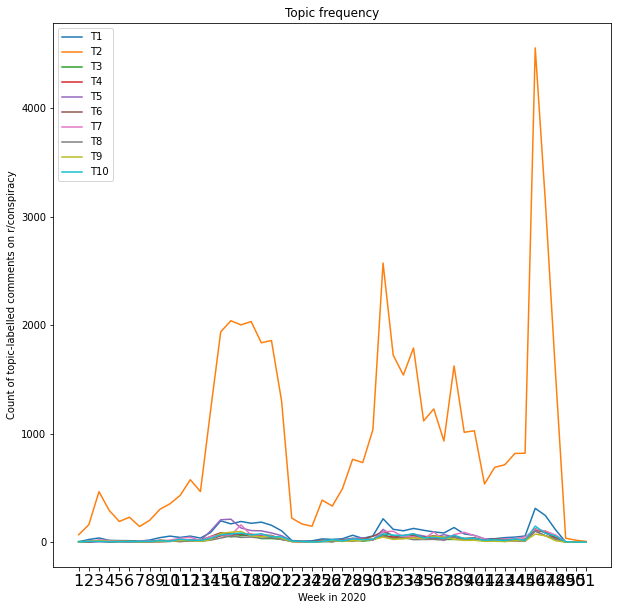

In [39]:
df_new = df_com_pp.groupby(['topic', 'week']).size().unstack('topic', fill_value = 0)
df_new = df_new[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']]

# # normalise by dividing each row by total coms that week
# for i in df_com_total.index:
#     df_new.loc[i] = df_new.loc[i]/df_com_total.loc[i]

# normalise by dividing each column by total coms of that topic
#df_new = df_new.divide(df_new.sum(axis=0), axis = 'columns')

fig, ax = plt.subplots()
fig.set_size_inches([10,10])
#ax = df_new.plot.bar(y='gates')
ax.plot(df_new.index,df_new)
ax.set_xticks(df_new.index.tolist())
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of topic-labelled comments on r/conspiracy')
ax.set_title('Topic frequency')
ax.legend(df_new.columns, loc='upper left')
# #plt.grid()
plt.show()


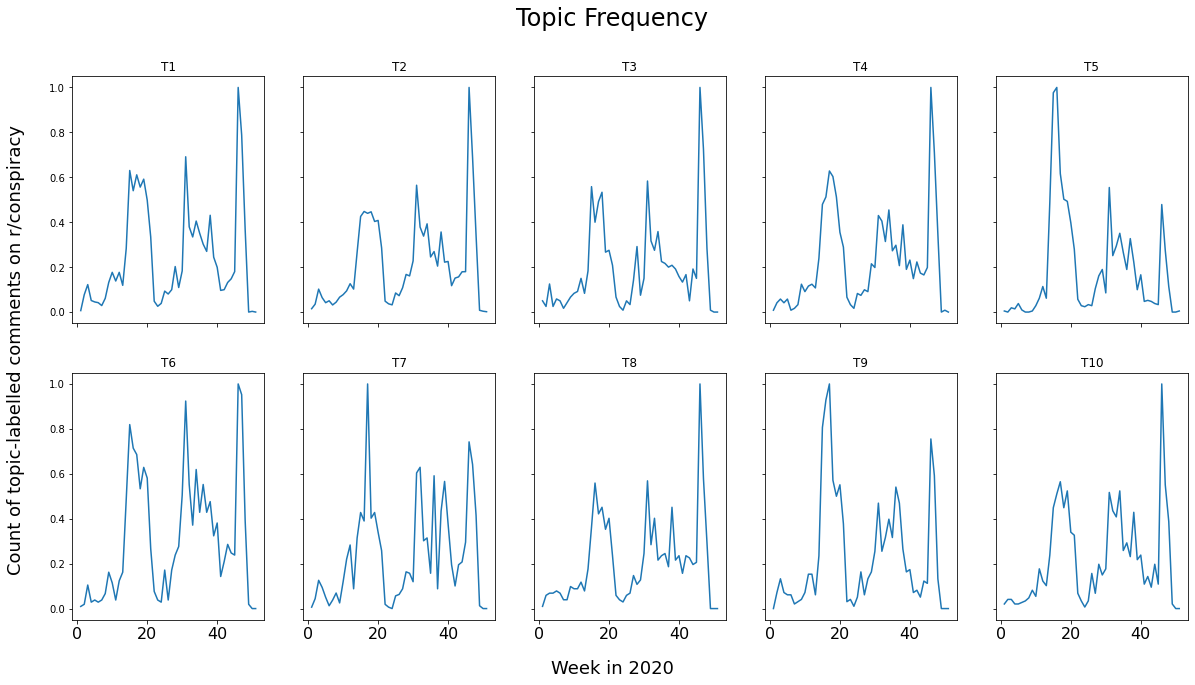

In [40]:
df_new = df_com_pp.groupby(['topic', 'week']).size().unstack('topic', fill_value = 0)
df_new = df_new[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']]

# normalise by dividing each column by max/total weekly count of comments with that topic
df_new = df_new.divide(df_new.max(axis=0), axis = 'columns')

fig, ax = plt.subplots(2,5, sharex='col', sharey='row')
fig.set_size_inches([20,10])
idx = 0
for i in range(2):
    for j in range(5):
        ax[i, j].plot(df_new.index,df_new.iloc[:,idx])
        ax[i, j].set_title(df_new.columns[idx])
        idx+=1
fig.text(0.5, 0.95, 'Topic Frequency', ha='center', fontsize=24)
fig.text(0.5, 0.05, 'Week in 2020', ha='center', fontsize=18)
fig.text(0.08, 0.5, 'Count of topic-labelled comments on r/conspiracy', va='center', rotation='vertical', fontsize=18)
plt.show()


* Plot year-topics ([Source](https://www.fruct.org/publications/fruct20/files/Kar2.pdf)) ([Source NB](https://github.com/cimsweb/Topic-Model-Visualization-With-IPython/blob/master/Topic%20Model%20Visualization%20With%20IPython.ipynb))

In [41]:
# model_nmf = model_objs_NMF['42']
# document_topics = model_nmf.fit_transform(cv_features)

NameError: name 'model_objs_NMF' is not defined

In [42]:
df_d_t_w = pd.DataFrame(document_topics)
df_d_t_w.head()

,0,1,2,3,4,5,6,7,8,9
0,0.00000,0.00794,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.00000,0.00552,0.00000,0.00000,0.00000,0.00470,0.00000,0.00000,0.00000,0.00000
2,0.00000,0.00670,0.03345,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.00000,0.00077,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01858
4,0.00000,0.00229,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [43]:
df_d_t_w = pd.DataFrame(document_topics, 
                        columns = ['T' + str(i + 1)  
                        for i in range(document_topics.shape[1])])
df_d_t_w['week'] = df_com_pp['week'].tolist()
l_col = df_d_t_w.columns.tolist()
l_col.remove('week')
# sum all the topic loading in a week
df_d_t_w = df_d_t_w.groupby(['week'])[l_col].apply(lambda x : x.sum())
# normalise by dividing each column by total coms of that topic
df_d_t_w = df_d_t_w.divide(df_d_t_w.sum(axis=1), axis = 'rows')
df_d_t_w.columns.name = 'topic'
df_d_t_w.head()

topic,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
week,,,,,,,,,,
1,0.13430,0.52152,0.12142,0.00000,0.04289,0.01714,0.00565,0.02302,0.02243,0.11163
2,0.10517,0.48657,0.06953,0.06075,0.00113,0.01464,0.08565,0.08846,0.02929,0.05880
3,0.14045,0.53907,0.05194,0.05037,0.01110,0.03874,0.04822,0.03518,0.05585,0.02907
4,0.08795,0.57048,0.06226,0.01425,0.00271,0.04184,0.10772,0.04362,0.03299,0.03618
5,0.12821,0.48351,0.04689,0.05818,0.04789,0.01793,0.06066,0.05755,0.08381,0.01536


In [44]:
from matplotlib import rcParams
color_sequence = [
'#2f4f4f','#7fffd4','#556b2f','#98fb98','#006400',
'#8b0000','#808000','#483d8b','#3cb371','#008b8b',
'#cd853f','#4682b4','#000080','#9acd32','#daa520',
'#8fbc8f','#800080','#b03060','#ff0000','#00ced1',
'#ff8c00','#ffff00','#0000cd','#deb887','#00ff00',
'#9400d3','#00ff7f','#00bfff','#9370db','#f08080',
'#adff2f','#ff6347','#da70d6','#ff00ff','#1e90ff',
'#f0e68c','#dda0dd','#add8e6','#8b4513','#808080',
'#ff69b4','#ffc0cb']
rcParams['font.family'] = 'Verdana'
rcParams['font.size'] = 16
rcParams['legend.fontsize'] = 8
rcParams['figure.figsize'] = 16, 10
rcParams['legend.frameon'] = True
#labels = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']
#plt.axis([0, 6, 0, 20])
#plt.xticks(labels)
df_d_t_w.plot.area(alpha=0.5, color=color_sequence,
                 title = 'Topic share per week',
                #grid = True,
                xticks = df_w_c.index.to_list())
plt.show()

NameError: name 'df_w_c' is not defined

---
## Optimise num_topics ( Non-negative Matrix Factorisation )

In [45]:
# Fucntion to find the best number of topics using coherence score. 
def test_NMFs(lower_topics = 4, upper_topics = 16, step_size = 2):
    num_models = (upper_topics - lower_topics) / step_size
    # Iterate through topic numbers to find an optimal number of topics
    mean_sim_scores = []
    models = {}
    count = 1
    for i in range(lower_topics, upper_topics, step_size): 
        print('Testing model', count, 'of', num_models)
        count += 1
#         nmf_model = NMF(n_components=i, solver='cd', max_iter=500,
#                         random_state=42, alpha=.1, l1_ratio=.85)
        nmf_model = NMF(n_components=i, init='nndsvd', max_iter=2000)
        nmf_model.fit_transform(cv_features)
        topic_terms_matrix = nmf_model.components_
        sim_matrix = cosine_similarity(topic_terms_matrix)
        mean_sim_scores.append(np.mean(sim_matrix))
        models[str(i)] = nmf_model

    # Plot the relationship between number of topics and the coherence score
    x = [i for i in range(lower_topics, upper_topics, step_size)]
    plt.figure(figsize=(16,9))
    plt.scatter(x, mean_sim_scores, marker='^', color='blue', label='Mean cosine similarity')
    plt.plot(x, [1/i for i in x], 'g',label=(r'$1/x$'))
    plt.scatter(x, [sim - 1/i for (sim,i) in zip(mean_sim_scores,x)], marker='o', color='red', label='Mean cs - 1/x')
    plt.xlabel('Number of Topics')
    plt.ylabel('Mean Pairwise Cosine Similarity Score')
    plt.grid(True)
    plt.xticks(x)
    #plt.axvline(x=30, c='black', ls='--')
    plt.legend()
    plt.show()
    
    return models, mean_sim_scores

Testing model 1 of 26.0
Testing model 2 of 26.0
Testing model 3 of 26.0
Testing model 4 of 26.0
Testing model 5 of 26.0
Testing model 6 of 26.0
Testing model 7 of 26.0
Testing model 8 of 26.0
Testing model 9 of 26.0
Testing model 10 of 26.0
Testing model 11 of 26.0
Testing model 12 of 26.0
Testing model 13 of 26.0
Testing model 14 of 26.0
Testing model 15 of 26.0
Testing model 16 of 26.0
Testing model 17 of 26.0
Testing model 18 of 26.0
Testing model 19 of 26.0
Testing model 20 of 26.0
Testing model 21 of 26.0
Testing model 22 of 26.0
Testing model 23 of 26.0
Testing model 24 of 26.0
Testing model 25 of 26.0
Testing model 26 of 26.0


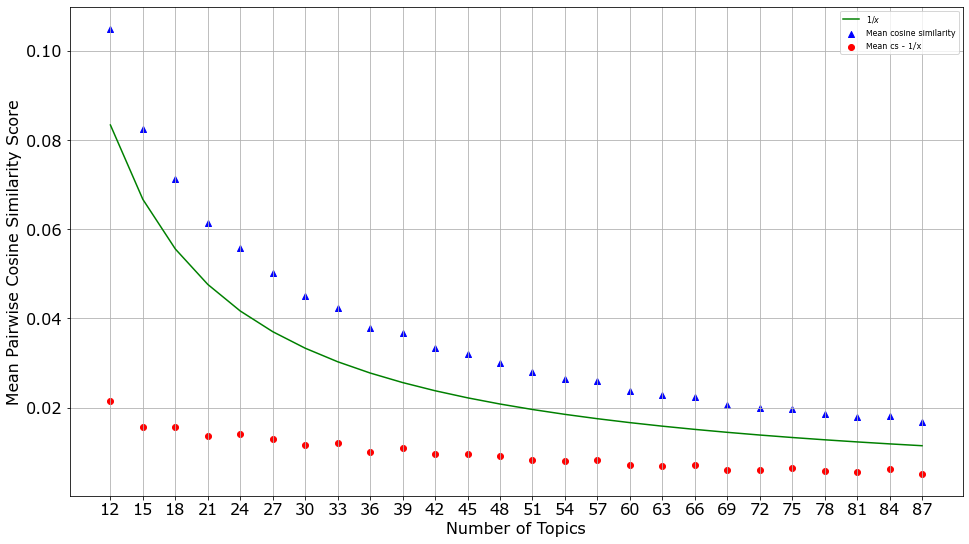

In [46]:
model_objs_NMF, sim_scores = test_NMFs(lower_topics = 12, upper_topics = 90, step_size = 3)

In [240]:
cv = CountVectorizer(min_df=0, max_df=0.5, ngram_range=(1,1),
                     token_pattern=None, tokenizer=lambda doc: doc,
                     preprocessor=lambda doc: doc)
cv_features = cv.fit_transform(df_com_pp['text']) #Learn the vocabulary dictionary (fit) and return document-term matrix (transform)
cv_features = transformer.fit_transform(cv_features)
cv_features.shape

vocabulary = np.array(cv.get_feature_names())
print('Total Vocabulary Size:', len(vocabulary))

(71441, 27726)

# HERE

In [324]:
# choose 42, 45 or 48
N_TOPICS = 42
model_nmf = model_objs_NMF[str(N_TOPICS)]
document_topics = model_nmf.fit_transform(cv_features)

In [318]:
# top_terms=20
topic_terms = model_nmf.components_
print(topic_terms.shape)
x = topic_terms[19,:]
print(np.linalg.norm(x))
x = x/np.linalg.norm(x)
np.linalg.norm(x)
# topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
# topic_keyterms = vocabulary[topic_key_term_idxs]
# topics = [', '.join(topic) for topic in topic_keyterms]
# #pd.set_option('display.max_colwidth', None)
# df_topics = pd.DataFrame(topics,
#                          columns = ['Terms per Topic'],
#                          index=['T'+str(t) for t in range(1,N_TOPICS +1)])
# df_topics.head()

(30, 27726)
3.150627294576293


0.9999999999999999

In [319]:
# normalise document_topics
document_topics_n = document_topics
for i in range(norm_vec.size):
    norm_vec = np.linalg.norm(topic_terms[i,:])
    document_topics_n[:,i] = document_topics[:,i]/norm_vec

---
## k-means clustering 

([Source](https://github.com/rahulpawar0712/K-means-clustering-with-the-iris-data-example-/blob/master/A%20K-means%20clustering%20with%20the%20iris%20data%20example%20.ipynb))

In [242]:
# from scipy.spatial.distance import cdist, pdist
# import seaborn as sns

In [320]:
k_means_fit = KMeans(n_clusters=11,max_iter=300) 
k_means_fit.fit(document_topics)
Counter(k_means_fit.labels_)

Counter({10: 8747,
         1: 41231,
         9: 795,
         2: 694,
         4: 6180,
         5: 3881,
         0: 2484,
         6: 1549,
         3: 3674,
         7: 940,
         8: 1266})

In [176]:
print ("\nSilhouette-score: %0.3f" % silhouette_score(document_topics, k_means_fit.labels_, metric='euclidean'))


Silhouette-score: 0.683


* Silhouette scores plot
    * The silhouette coefficient values in the preceding results shows that K value 2 and K value 3 have better scores than all the other values. As a thumb rule, we need to take the next K value of the highest silhouette coefficient. Here, we can say that K value 3 is better. In addition, we also need to see the average within cluster variation value and elbow plot before concluding the optimal K value. ([Source](https://github.com/rahulpawar0712/K-means-clustering-with-the-iris-data-example-/blob/master/A%20K-means%20clustering%20with%20the%20iris%20data%20example%20.ipynb))

    * The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. ([Wiki](https://en.wikipedia.org/wiki/Silhouette_(clustering)))
    
    

* Gap statistic plot
    * The gap statistic was developed by Stanford researchers Tibshirani, Walther and Hastie in their 2001 paper. The idea behind their approach was to find a way to standardize the comparison of \log W_k with a null reference distribution of the data, i.e. a distribution with no obvious clustering. Their estimate for the optimal number of clusters K is the value for which \log W_k falls the farthest below this reference curve. This information is contained in the following formula for the gap statistic:

     [Code](https://github.com/teruo41/calc_k_with_gap) 

    [Source](https://datasciencelab.wordpress.com/tag/gap-statistic/)
    
    alternate implementation ipynb ([Source](https://github.com/Mavengence/Pattern_Analysis_SS20_FAU/blob/master/Exercise_6.ipynb))

In [178]:
import importlib
import calc_k_with_gap
importlib.reload(calc_k_with_gap)
from calc_k_with_gap import calc_k_with_gap

n_clusters, gaps, sks, silh_scores = calc_k_with_gap(document_topics, max_k=16)
#k, gaps, sks = calc_k_with_gap(document_topics, max_k=10)

calc_k_with_gap() preparing...
calc_k_with_gap() preparing...   Done.
calc_k_with_gap() iteration for i =  0
calc_k_with_gap() iteration for i =  1
calc_k_with_gap() iteration for i =  2
calc_k_with_gap() iteration for i =  3
calc_k_with_gap() iteration for i =  4
calc_k_with_gap() iteration for i =  5
calc_k_with_gap() iteration for i =  6
calc_k_with_gap() iteration for i =  7
calc_k_with_gap() iteration for i =  8
calc_k_with_gap() iteration for i =  9
calc_k_with_gap() iteration for i =  10
calc_k_with_gap() iteration for i =  11
calc_k_with_gap() iteration for i =  12
calc_k_with_gap() iteration for i =  13


Text(0, 0.5, 'Gap stat')

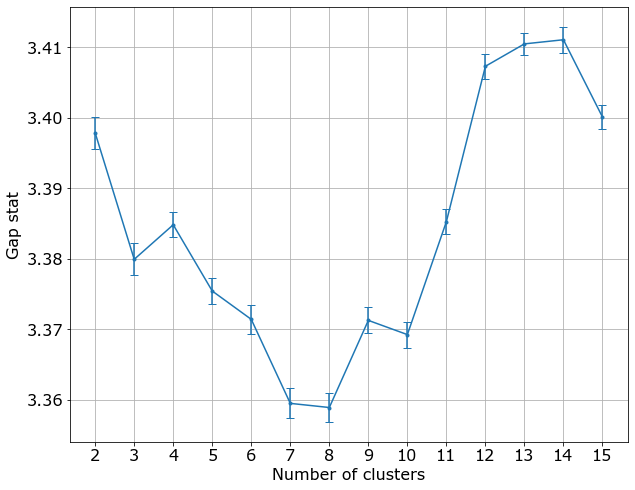

In [183]:
# gap stat
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
#ax.scatter(range(1,k+1), gaps[:-1], c='blue', marker='.')
ax.errorbar(n_clusters[:-2], gaps[:-2],yerr=6*sks[:-2], capsize=4, marker='.')
ax.set_xticks(n_clusters[:-2])
plt.grid(True) 
plt.xlabel('Number of clusters') 
plt.ylabel('Gap stat')

Text(0, 0.5, 'Silhouette Score')

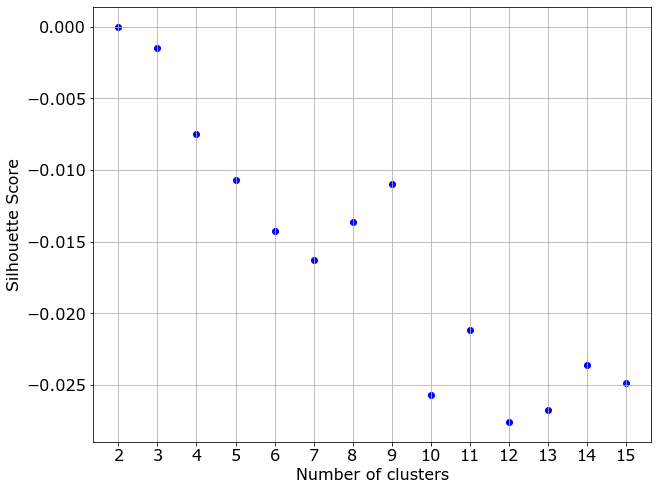

In [185]:
# silhouette scores
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
ax.scatter(n_clusters[:-2], silh_scores[:-2], c='blue', marker='o')
ax.set_xticks(n_clusters[:-2])
plt.grid(True) 
plt.xlabel('Number of clusters') 
plt.ylabel('Silhouette Score')

* PVE Plot ([Colab NB](https://colab.research.google.com/drive/1xfBdZIQ5uf6ktc9zfzjshO65fbrcV8AP))

In [ ]:
# Image(out_dir + '\\within_cluster_ss.png')

In [ ]:
# Image(out_dir + '\\pve.png')

# HERE

* Do the clustering with N_CLUSTERS selected

In [325]:
N_CLUSTERS=11 # 11 or 7?

In [326]:
#k_means_fit = KMeans(n_clusters=N_CLUSTERS,max_iter=300) 
k_means_fit = KMeans(n_clusters=N_CLUSTERS, max_iter=300, random_state=42)
k_means_fit.fit(document_topics)

KMeans(n_clusters=11, random_state=42)

In [369]:
cntr = Counter(k_means_fit.labels_).most_common()
cntr_labels = [x for x,y in cntr]
idx = np.array(cntr_labels)
lut = np.zeros_like(idx)
lut[idx] = np.arange(N_CLUSTERS) + 1
Counter(lut[k_means_fit.labels_]).most_common()

[(1, 41801),
 (2, 10289),
 (3, 6116),
 (4, 3363),
 (5, 2960),
 (6, 1543),
 (7, 1427),
 (8, 1401),
 (9, 993),
 (10, 849),
 (11, 699)]

In [371]:
df_com_pp['cluster'] = lut[k_means_fit.labels_]
df_com_pp.to_csv(out_file)

* plot week-cluster

In [372]:
df_temp = df_com_pp[['week','cluster']].copy()
df_temp.head()

df_w_c = df_temp.pivot_table(index = 'week', columns = 'cluster', aggfunc=len, fill_value=0)
df_w_c = df_w_c.add_prefix('C')
# normalise by dividing each column by total coms of that topic
df_w_c = df_w_c.divide(df_w_c.sum(axis=1), axis = 'rows')
df_w_c.head()

cluster,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11
week,,,,,,,,,,,
1,0.64286,0.11905,0.04762,0.07143,0.01190,0.01190,0.00000,0.03571,0.00000,0.03571,0.02381
2,0.60909,0.15000,0.03636,0.04091,0.08636,0.00000,0.00455,0.02273,0.01818,0.01818,0.01364
3,0.53925,0.21843,0.06314,0.05119,0.06314,0.00171,0.01536,0.00853,0.01024,0.00853,0.02048
4,0.61972,0.20845,0.07042,0.03099,0.02535,0.00000,0.01408,0.00845,0.00282,0.00845,0.01127
5,0.54118,0.20392,0.09020,0.06275,0.02745,0.01569,0.00392,0.00000,0.02353,0.01176,0.01961


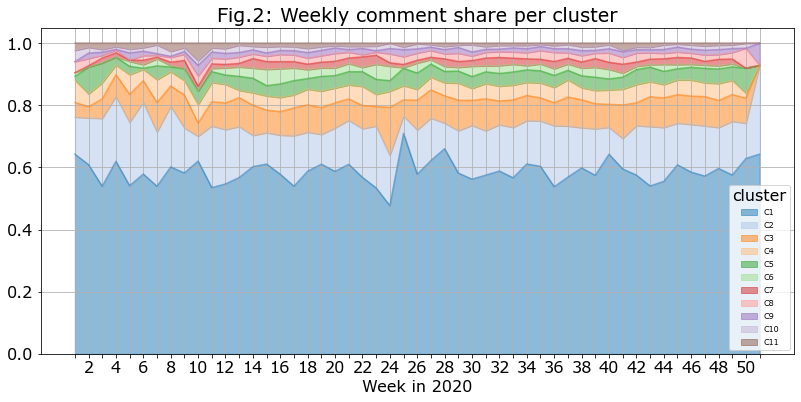

In [398]:
from matplotlib import rcParams
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
                 '#800080', '#FF00FF', '#000080', '#0000FF', '#008080',
                  '#00FFFF', '#008000', '#00FF00', '#808000', '#FFFF00',
                  '#800000', '#FF0000', '#000000', '#808080', '#C0C0C0',
                  '#FFFFFF', '#B22222', '#F08080', '#FF69B4', '#FF7F50',
                  '#FFFF00',
                  '#BDB76B', '#BC8F8F', '#8B4513', '#00008B', '#FFE4E1',
                  '#008080',
                  '#00CED1', '#00CED1']
rcParams['font.family'] = 'Verdana'
rcParams['font.size'] = 16
rcParams['legend.fontsize'] = 8
rcParams['xtick.labelsize'] = 8
#rcParams['figure.figsize'] = 16, 10 #4.6, 2.9
rcParams['legend.frameon'] = True
rcParams['xtick.labelsize'] = 16
#labels = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']
#plt.axis([0, 6, 0, 20])
ax = df_w_c.plot.area(alpha=0.5, color=color_sequence, 
                 title = 'Fig.2: Weekly comment share per cluster',
                grid = True,
                xticks = df_w_c.index.to_list(),
                figsize=(4.5*3, 2.0*3))
ax.set_xlabel('Week in 2020')
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.savefig(out_dir+'\\cluster_share_week.pdf', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

In [193]:
from sklearn.manifold import TSNE # TSNE module

# Invoke the TSNE method
X = document_topics
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(X)

# from sklearn.preprocessing import StandardScaler
# X_std = StandardScaler().fit_transform(X)
# # Invoke the TSNE method
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
# tsne_results_std = tsne.fit_transform(X_std)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 71441 samples in 0.007s...
[t-SNE] Computed neighbors for 71441 samples in 117.190s...
[t-SNE] Computed conditional probabilities for sample 1000 / 71441
[t-SNE] Computed conditional probabilities for sample 2000 / 71441
[t-SNE] Computed conditional probabilities for sample 3000 / 71441
[t-SNE] Computed conditional probabilities for sample 4000 / 71441
[t-SNE] Computed conditional probabilities for sample 5000 / 71441
[t-SNE] Computed conditional probabilities for sample 6000 / 71441
[t-SNE] Computed conditional probabilities for sample 7000 / 71441
[t-SNE] Computed conditional probabilities for sample 8000 / 71441
[t-SNE] Computed conditional probabilities for sample 9000 / 71441
[t-SNE] Computed conditional probabilities for sample 10000 / 71441
[t-SNE] Computed conditional probabilities for sample 11000 / 71441
[t-SNE] Computed conditional probabilities for sample 12000 / 71441
[t-SNE] Computed conditional probabilities for 

NameError: name 'target' is not defined

<Figure size 1152x792 with 0 Axes>

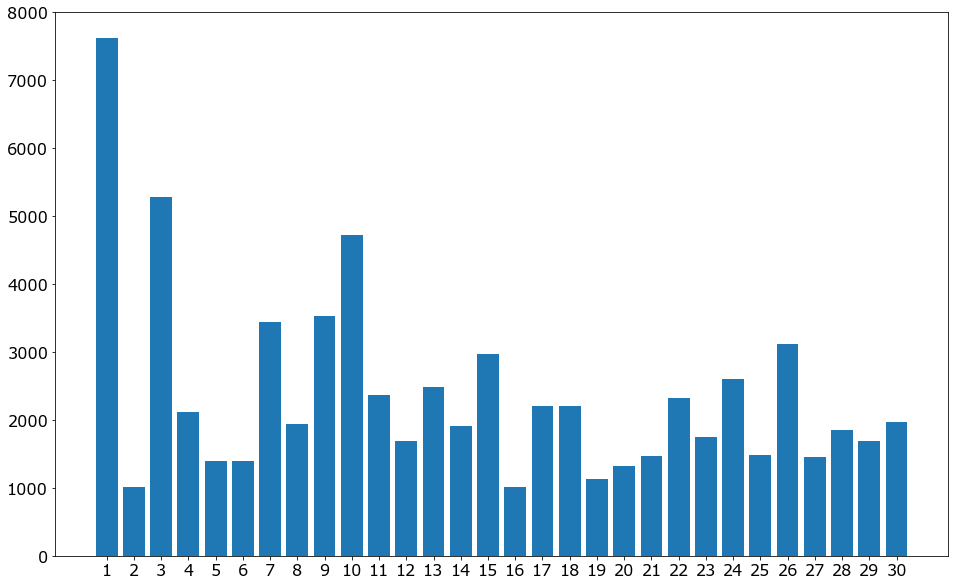

In [321]:
dt_df = pd.DataFrame(document_topics_n, 
                     columns=[i for i in range(1, N_TOPICS+1)])
topic_labels = dt_df.idxmax(axis=1)
len(topic_labels)
plt.figure()
plt.bar(Counter(topic_labels).keys(),Counter(topic_labels).values())
plt.xticks(range(1,31))
plt.show()

# dt_df['mag'] = dt_df.apply(np.linalg.norm, axis=1)
# dt_df['cluster'] = k_means_fit.labels_
# print(dt_df.groupby('cluster')['mag'].size())
# dt_df.groupby('cluster')['mag'].apply(lambda x: x.std())

In [275]:
dt_df.apply(np.sum, axis=1)

0       5.20532
1       8.16695
2       4.27640
3       3.11428
4       5.07633
          ...  
71436   5.16931
71437   5.32179
71438   1.21377
71439   3.01808
71440   8.16997
Length: 71441, dtype: float64

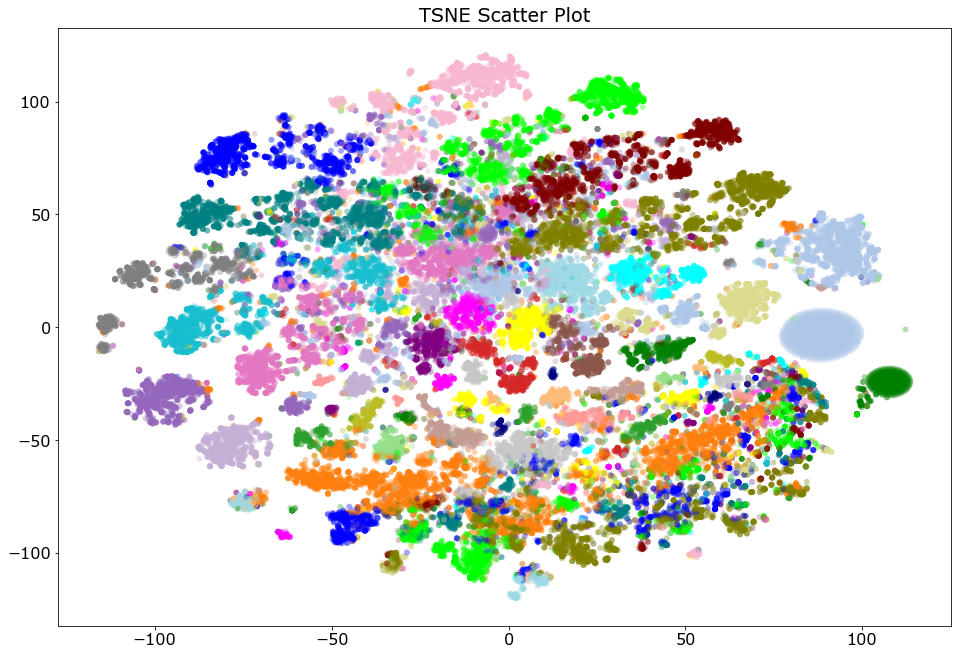

In [210]:
# target = k_means_fit.labels_
target = [color_sequence[i] for i in topic_labels]
plt.figure(figsize = (16,11))
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = target,
            edgecolor = "None", alpha=0.35)
#plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

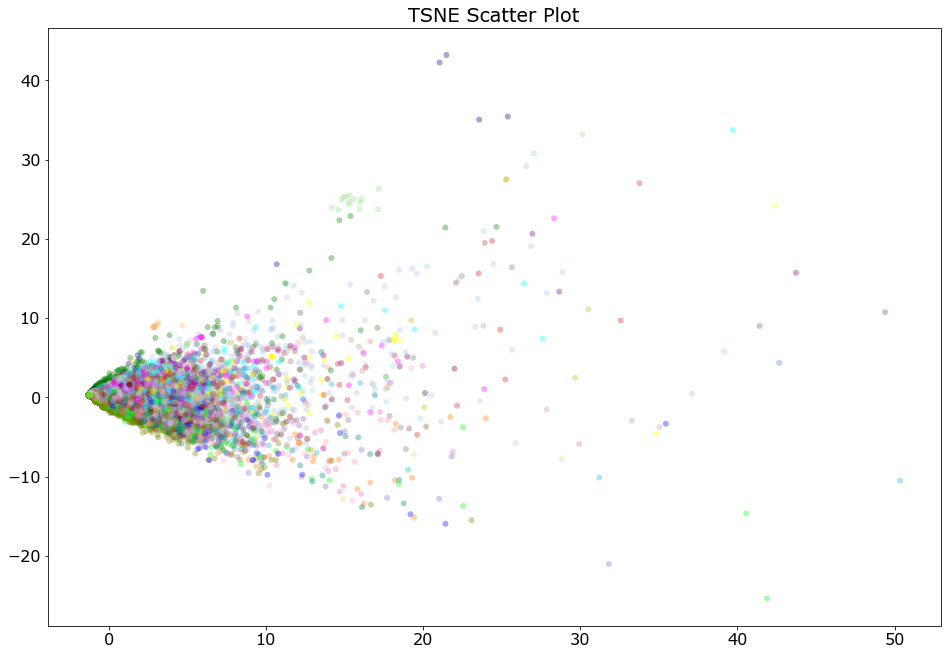

In [239]:

from sklearn.decomposition import PCA # Principal Component Analysis module
pca = PCA(n_components=2)
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
pca_2d = pca.fit_transform(X_std)

plt.figure(figsize = (16,11))
plt.scatter(pca_2d[:,0],pca_2d[:,1],  c = target,
            edgecolor = "None", alpha=0.35)
#plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

# HERE

* plot cluster-topic loadings

In [374]:
df_d_t_c = pd.DataFrame(document_topics, 
                        columns = ['T' + str(i + 1)  
                        for i in range(document_topics.shape[1])])
df_d_t_c['cluster'] = df_com_pp['cluster'].tolist()
l_col = df_d_t_c.columns.tolist()
l_col.remove('cluster')
df_d_t_c_std = df_d_t_c.groupby(['cluster'])[l_col].apply(lambda x : x.std())
# mean of topic loadings per cluster
df_d_t_c = df_d_t_c.groupby(['cluster'])[l_col].apply(lambda x : x.mean())
df_d_t_c.columns.name = 'topic'
df_d_t_c

topic,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,...,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42
cluster,,,,,,,,,,,,,,,,,,,,,
1,0.00494,0.00035,0.00162,0.00071,0.00054,0.00060,0.00065,0.00330,0.00108,0.00173,...,0.00175,0.00300,0.00144,0.00207,0.00349,0.00201,0.00272,0.00225,0.00285,0.00185
2,0.00519,0.00019,0.04714,0.00148,0.00057,0.00064,0.00090,0.00790,0.00414,0.00359,...,0.00153,0.00359,0.00101,0.00350,0.00271,0.00755,0.00245,0.00155,0.00232,0.00118
3,0.00592,0.00015,0.00875,0.00110,0.00093,0.00082,0.00196,0.00758,0.04135,0.00252,...,0.00421,0.00313,0.00126,0.00367,0.00181,0.00325,0.00427,0.00273,0.00313,0.00147
4,0.00558,0.00023,0.00685,0.00105,0.00104,0.00093,0.00150,0.00451,0.00749,0.00203,...,0.00217,0.00305,0.00135,0.00230,0.00284,0.00254,0.00371,0.00250,0.00297,0.00275
5,0.00518,0.00026,0.00766,0.00092,0.00116,0.00103,0.00161,0.00421,0.00621,0.00198,...,0.00146,0.00315,0.00167,0.00236,0.00271,0.00404,0.00299,0.00281,0.00310,0.00118
6,0.00362,0.00015,0.01249,0.08933,0.00113,0.00089,0.00423,0.00330,0.00464,0.00123,...,0.00084,0.00293,0.00138,0.00205,0.00254,0.00168,0.00218,0.00224,0.00286,0.00089
7,0.00328,0.00008,0.00656,0.00180,0.00068,0.00081,0.07668,0.00435,0.00453,0.00136,...,0.00174,0.00246,0.00270,0.00254,0.00210,0.00130,0.00222,0.00700,0.00205,0.00085
8,0.00350,0.00014,0.00543,0.00111,0.00137,0.00146,0.00163,0.00330,0.00310,0.00118,...,0.00115,0.00266,0.00191,0.00178,0.00251,0.00172,0.00199,0.00223,0.00362,0.00148
9,0.00222,0.00020,0.00324,0.00033,0.10246,0.00046,0.00250,0.00296,0.00197,0.00099,...,0.00108,0.00165,0.00166,0.00139,0.00186,0.00108,0.00153,0.00210,0.00150,0.00116


In [375]:
from scipy.stats import ttest_1samp
# H_0: the mean result of students in school #2 is greater or equal to 90
# H_1: the mean result of students in school #2 is less than 90
test_2 = ttest_1samp(df_d_t_c.iloc[0,:], 0.0071)
1 - test_2.pvalue / 2 # less than 0.01

1.0

In [376]:
from scipy.stats import ttest_ind
# H_0: the mean result of students from school #1 is the same as the mean result from school #2
# H_1: the mean result of students from school #1 and #2 are not equal
test_3 = ttest_1samp(df_d_t_c.iloc[0,:], df_d_t_c.iloc[0,:])
test_3.pvalue # less than 0.01

array([1.71209799e-21, 9.47279947e-14, 7.58830438e-03, 7.84404433e-11,
       2.94109231e-12, 9.33574887e-12, 2.34090366e-11, 7.52632908e-10,
       1.45468980e-07, 3.75270041e-02, 2.87280733e-10, 6.08029370e-10,
       7.29179427e-02, 4.86996245e-17, 2.10357423e-04, 4.25024877e-11,
       3.72431973e-05, 8.58883980e-02, 5.26424296e-02, 6.84916045e-06,
       2.30784790e-04, 5.53200254e-06, 1.15407107e-03, 9.30249994e-01,
       4.53318535e-01, 6.91642630e-02, 2.00909778e-01, 1.19271008e-02,
       4.24437471e-03, 4.20598893e-09, 2.41894184e-02, 8.59305908e-01,
       5.08657600e-02, 3.93601959e-07, 2.42853722e-04, 9.63476547e-01,
       1.75394072e-11, 7.17851737e-01, 1.33937948e-04, 2.46931189e-01,
       9.36175986e-06, 1.78956776e-01])

In [377]:
6*np.std(df_d_t_c.iloc[0,:]) + np.mean(df_d_t_c.iloc[0,:])

0.008053292101573262

---
* Top n-most varying topics

In [378]:
# most varying top n topics
s_topics_std = df_d_t_c.std()
s_topics = s_topics_std.nlargest(20)
s_topics

topic
T2    0.05767
T6    0.03813
T5    0.03063
T4    0.02666
T7    0.02267
T11   0.02091
T12   0.01626
T16   0.01388
T3    0.01306
T9    0.01166
T30   0.00267
T8    0.00234
T38   0.00209
T14   0.00190
T1    0.00183
T29   0.00181
T40   0.00170
T31   0.00167
T22   0.00153
T28   0.00142
dtype: float64

In [379]:
df_d_t_c[s_topics.index]

topic,T2,T6,T5,T4,T7,T11,T12,T16,T3,T9,T30,T8,T38,T14,T1,T29,T40,T31,T22,T28
cluster,,,,,,,,,,,,,,,,,,,,
1,0.00035,0.00060,0.00054,0.00071,0.00065,0.00077,0.00081,0.00068,0.00162,0.00108,0.00322,0.00330,0.00201,0.00422,0.00494,0.00253,0.00225,0.00170,0.00288,0.00247
2,0.00019,0.00064,0.00057,0.00148,0.00090,0.00132,0.00229,0.00192,0.04714,0.00414,0.00907,0.00790,0.00755,0.00486,0.00519,0.00547,0.00155,0.00259,0.00460,0.00129
3,0.00015,0.00082,0.00093,0.00110,0.00196,0.00162,0.00245,0.00235,0.00875,0.04135,0.00646,0.00758,0.00325,0.00691,0.00592,0.00559,0.00273,0.00329,0.00501,0.00200
4,0.00023,0.00093,0.00104,0.00105,0.00150,0.00201,0.00269,0.04788,0.00685,0.00749,0.00399,0.00451,0.00254,0.00549,0.00558,0.00272,0.00250,0.00445,0.00460,0.00220
5,0.00026,0.00103,0.00116,0.00092,0.00161,0.00188,0.05573,0.00298,0.00766,0.00621,0.00457,0.00421,0.00404,0.00564,0.00518,0.00353,0.00281,0.00586,0.00308,0.00203
6,0.00015,0.00089,0.00113,0.08933,0.00423,0.00198,0.00249,0.00260,0.01249,0.00464,0.00242,0.00330,0.00168,0.00436,0.00362,0.00198,0.00224,0.00182,0.00356,0.00201
7,0.00008,0.00081,0.00068,0.00180,0.07668,0.00116,0.00236,0.00198,0.00656,0.00453,0.00247,0.00435,0.00130,0.00347,0.00328,0.00167,0.00700,0.00266,0.00236,0.00214
8,0.00014,0.00146,0.00137,0.00111,0.00163,0.07096,0.00212,0.00310,0.00543,0.00310,0.00144,0.00330,0.00172,0.00440,0.00350,0.00142,0.00223,0.00195,0.00279,0.00223
9,0.00020,0.00046,0.10246,0.00033,0.00250,0.00249,0.00158,0.00265,0.00324,0.00197,0.00146,0.00296,0.00108,0.00292,0.00222,0.00118,0.00210,0.00235,0.00123,0.00292


In [380]:
top_terms=20
topic_terms = model_nmf.components_
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
#pd.set_option('display.max_colwidth', None)
df_topics = pd.DataFrame(topics,
                         columns = ['Terms per Topic'],
                         index=['T'+str(t) for t in range(1,N_TOPICS +1)])
df_topics.head()

,Terms per Topic
T1,"us, time, use, thing, way, even, world, believ, mean, could, much, come, tri, also, govern, realli, actual, fact, control, live"
T2,"remov, remov_rule, rule, comment, r, user, rather, argument, video, youtub, address_argument, meta_sticki, rather_user, comment_outsid, comment_per, user_rather, argument_happi, remov_section, rea..."
T3,"vaccin, polio, mandatori, safe, caus, develop, rush, forc, diseas, children, anti, safeti, injuri, trial, manufactur, autism, ss, risk, alreadi, kid"
T4,"gate, bill, bill_gate, fund, foundat, trust, evil, gate_foundat, melinda, bill_melinda, africa, ss, epstein, world, plan, rockefel, involv, fauci, microchip, popul"
T5,"lol, ok, dude, exactli, love, sub, k, nice, thought, funni, liter, man, yea, bro, that, got, shill, even, realli, oh"


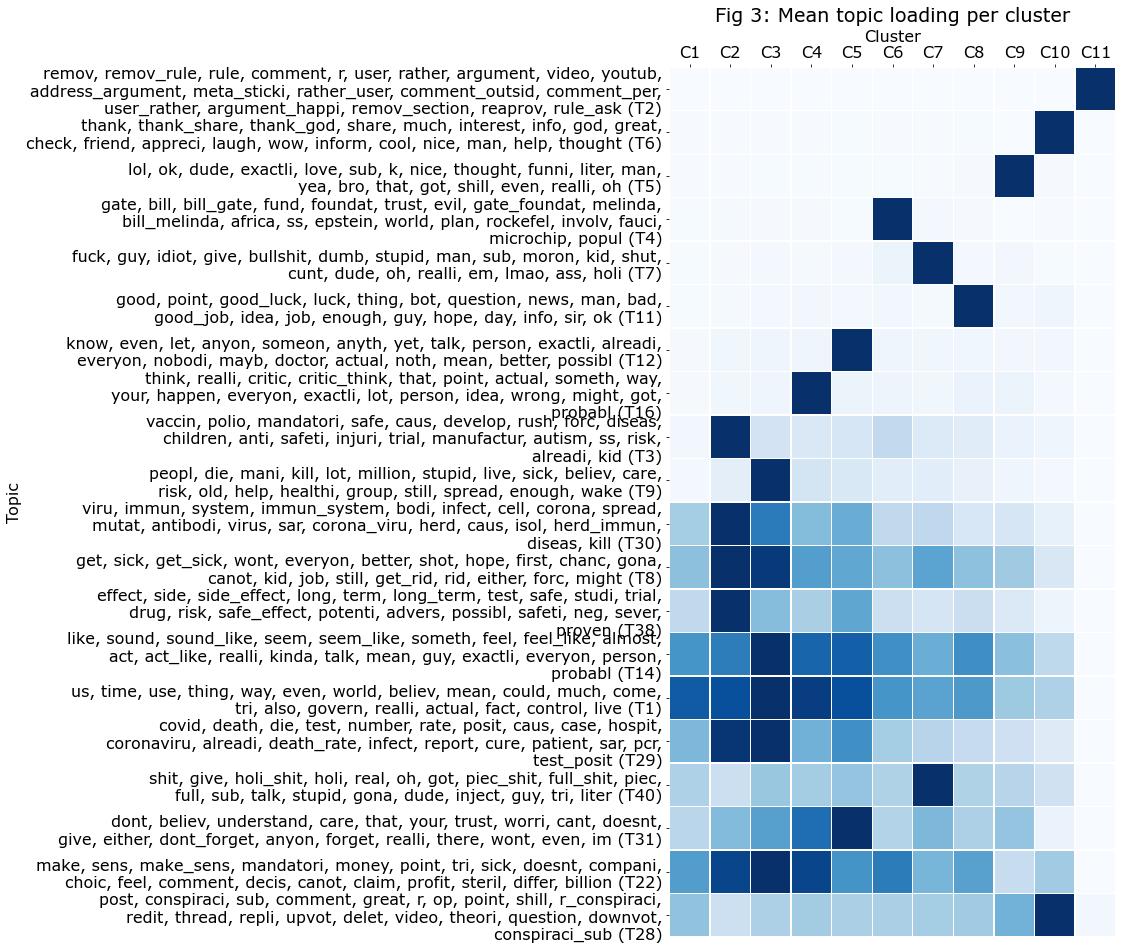

In [384]:
import matplotlib
def wrap_labels(text, width=75):
    lines = textwrap.wrap(text, width, break_long_words=False)
    return '\n'.join(lines)

# use only top 15 varying topics
df_temp = df_d_t_c[s_topics.index].copy()
# normalise by dividing each column by max loading of that topic
df_temp = df_temp.divide(df_temp.max(axis=0), axis = 'columns')

fig, ax = plt.subplots(figsize=(8, 16))
sb.heatmap(df_temp.T, square=False,
           linewidth=0.3, cbar_kws={"shrink": .8}, cbar=False,
          cmap="Blues"
          )
# yticks
#yticks = data.inde
yticks_labels = df_topics.loc[s_topics.index]['Terms per Topic'].to_list()
yticks_labels = [wrap_labels(s)+' ('+T+')' for s,T in zip(yticks_labels, s_topics.index.to_list())]
yt = np.arange(len(yticks_labels)) + 0.5
#plt.yticks(rotation = 0, ticks = yt, labels = yticks_labels)
plt.yticks(yt, yticks_labels, rotation=0)

# xticks
rcParams['xtick.labelsize'] = 16
ax.xaxis.tick_top()
xticks_labels = df_w_c.columns.to_list()
xt = np.arange(len(xticks_labels)) + 0.5
plt.xticks(xt, xticks_labels)
# axis labels
ax.xaxis.set_label_position('top')
plt.xlabel('Cluster')
plt.ylabel('Topic')
# title
title = 'Fig 3: Mean topic loading per cluster\n'
plt.title(title, loc='center', y=1.02)
plt.savefig(out_dir+'\\topic_cluster.pdf', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

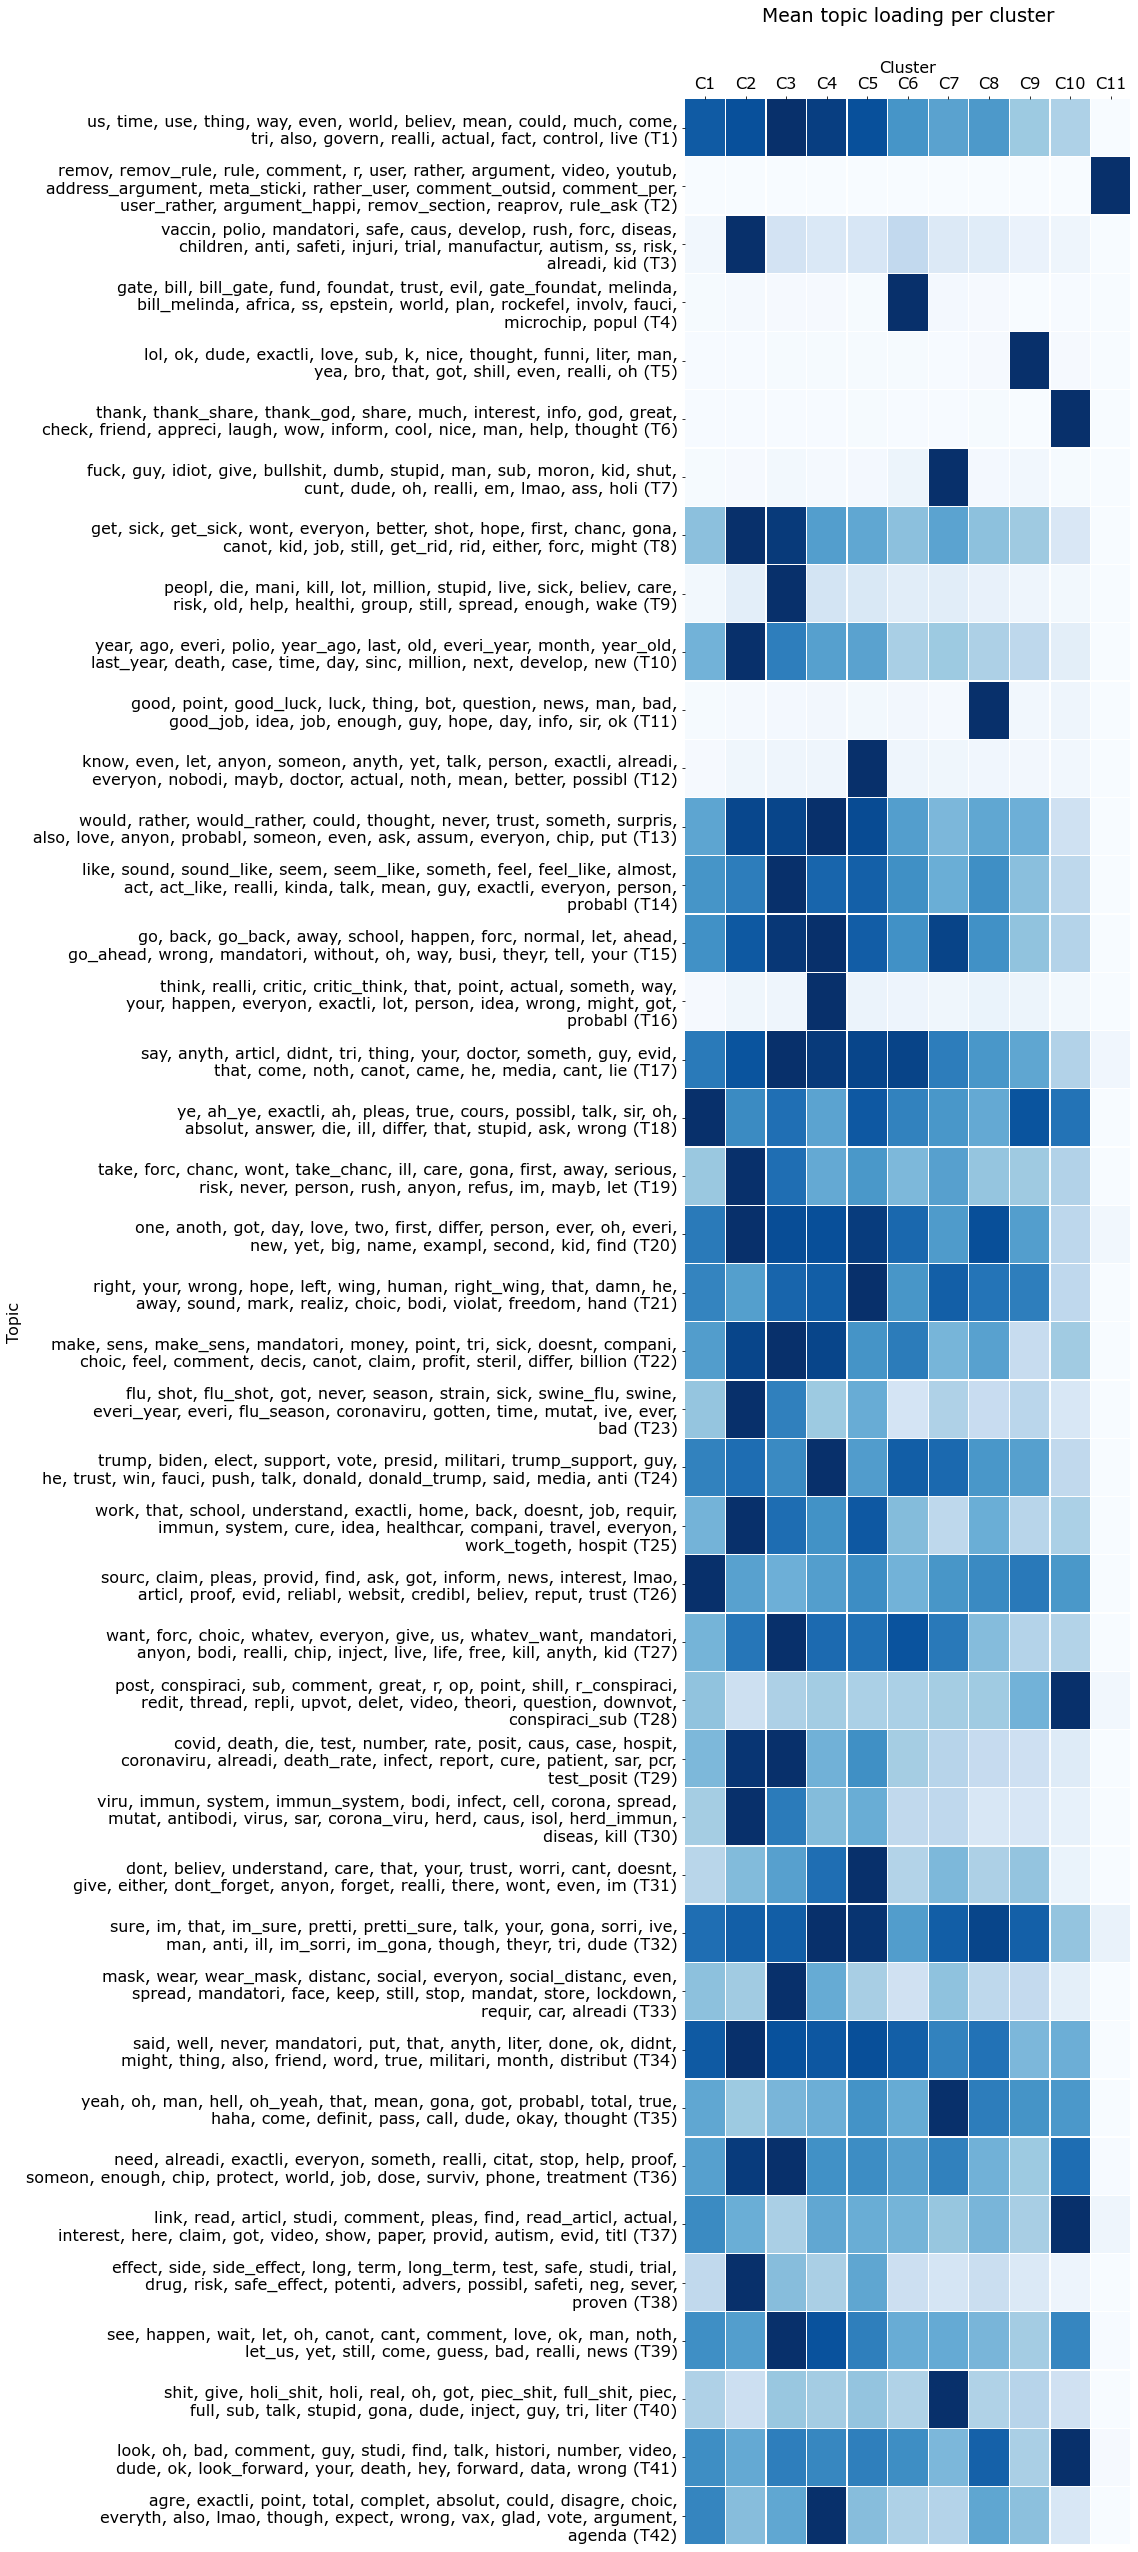

In [382]:
# use all topics
df_temp = df_d_t_c.copy()
# normalise by dividing each column by max loading of that topic
df_temp = df_temp.divide(df_temp.max(axis=0), axis = 'columns')

fig, ax = plt.subplots(figsize=(8, 45))
sb.heatmap(df_temp.T, cmap="Blues", square=False,
           linewidth=0.3, cbar_kws={"shrink": .8}, cbar=False)
# yticks
#yticks = data.inde
yticks_labels = df_topics['Terms per Topic'].to_list()
yticks_labels = [wrap_labels(s)+' ('+T+')' for s,T in zip(yticks_labels, df_topics.index.to_list())]
yt = np.arange(len(yticks_labels)) + 0.5
#plt.yticks(rotation = 0, ticks = yt, labels = yticks_labels)
plt.yticks(yt, yticks_labels, rotation=0)

# xticks
rcParams['xtick.labelsize'] = 16
ax.xaxis.tick_top()
xticks_labels = df_w_c.columns.to_list()
xt = np.arange(len(xticks_labels)) + 0.5
plt.xticks(xt, xticks_labels)
# axis labels
ax.xaxis.set_label_position('top')
plt.xlabel('Cluster')
plt.ylabel('Topic')
# title
title = 'Mean topic loading per cluster\n'
plt.title(title, loc='center', y=1.02)
#plt.savefig(out_dir+'\\topic_cluster_all_topics.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

---
---
---
## Parking lot
  * text analysis with python vid [link](https://www.youtube.com/watch?v=ALGd_frv4rc&feature=youtu.be&ab_channel=J%C3%BCrgenPfeffer)
  * SNA in python vids [link](https://www.youtube.com/playlist?list=PLW5N2mhH4QJqRKrHLWs052mhXyFAsQn-v) 

* pandas find word in str :

In [118]:
# find_word = 'aascsadv'
# df_com[df_com['text'].str.contains(find_word, case=False)]['text'].tolist()

* pandas find token in list :

In [119]:
# find_tkn = '2020comentcomit'  
# df_temp = df_com_pp[df_com_pp.apply(lambda x: find_tkn in x['text'], axis=1)][['text','text_og','link']]

# find_tkn_ind = df_temp.iloc[0, df_temp.columns.get_loc('text')].index(find_tkn)
# print(find_tkn_ind)
# df_temp.iloc[0, df_temp.columns.get_loc('text')][find_tkn_ind-5:find_tkn_ind+5]

# df_temp.iloc[0,df_temp.columns.get_loc('text_og')]

* Pandas positional and label-based indexing :

In [120]:
# df_temp.iloc[0, df_temp.columns.get_loc('text')][40:50]
# dfd.iloc[[0, 2], dfd.columns.get_indexer(['A', 'B'])]
# dfd.loc[dfd.index[[0, 2]], 'A']

* Display df unlimited

In [121]:
# with pd.option_context('display.max_colwidth', None):
#     #pd.set_option('display.max_columns', None)
#     display(df_temp)

* Save matrix

In [122]:
# filename = data_dir + '\\' + 'document_topics.npy'
# np.save(filename, document_topics)
# # np.load(filename)

We would clearly expect that the words that appear most frequently in one topic would appear less frequently in the other - otherwise that word wouldn't make a good choice to separate out the two topics. Therefore, we expect the topics to be **orthogonal**.

The SVD algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (along with a diagonal matrix, which contains the **relative importance** of each factor).

<img src="images/svd_fb.png" alt="" style="width: 80%"/>
(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

SVD is an **exact decomposition**, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science, including:

- semantic analysis
- collaborative filtering/recommendations ([winning entry for Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis

SVD -> NMF

Rather than constraining our factors to be *orthogonal*, another idea would to constrain them to be *non-negative*. NMF is a factorization of a non-negative data set $V$: $$ V = W H$$ into non-negative matrices $W,\; H$. Often positive factors will be **more easily interpretable** (and this is the reason behind NMF's popularity). 

<img src="images/face_nmf.png" alt="NMF on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

Construct a face with linear combinations of features
Nonnegative matrix factorization (NMF) is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix.  NMF is NP-hard and non-unique.  There are a number of variations on it, created by adding different constraints. 

- Topic Modeling (our problem!)

<img src="images/nmf_doc.png" alt="NMF on documents" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

In [123]:
# from sklearn.metrics.pairwise import cosine_similarity
# import math

# def nCr(n,r):
#     f = math.factorial
#     return f(n) // f(r) // f(n-r)

# def mean_pairwise_cosine_sim(topic_terms, num_topics):
#     sim_matrix = cosine_similarity(topic_terms) # Construct a topic similarity matrix
#     return np.mean(sim_matrix) # Get Mean pairwise cosine similarity for each vector in the topic-word mapping 
#     #return np.tril(sim_matrix, -1).sum()/nCr(num_topics, 2) # Get Mean pairwise cosine similarity for each vector in the topic-word mapping 

In [124]:
# import dill
# filename = data_dir + "\\" + 'notebook_session_02_02_1251.db'
# dill.dump_session(filename)
# #dill.load_session('notebook_session.db')

In [125]:
# # Matplotlib issue
# import matplotlib
# # importlib.reload(matplotlib)
# print(matplotlib.__version__)
# print(matplotlib.__file__)